# Bài toán

Trong notebook này, chúng ta sẽ ứng dụng thuật toán hồi quy tuyến tính mà chúng ta đã học trong khóa học này.

Hãy đọc dữ liệu bằng thư viện Pandas, sau đó sử dụng thuật toán hồi quy tuyến tính với các đặc trưng khác nhau nhằm tìm ra thuật toán hồi quy tuyến tính tốt nhất thông qua phương pháp đánh giá độ chính xác.

Tập dữ liệu và bài toán thuộc dạng hồi quy cổ điển. Với một số đặc trưng nhất định, chúng ta cần xây dựng một mô hình hồi quy tuyến tính để xác định **số lượng hồ sơ được chấp nhận** dựa vào các đặc trưng đã có.

Để giải quyết bài toán này, chúng ta cần phân tích dữ liệu, thực hiện bất kỳ chuyển đổi và chuẩn hóa cần thiết nào, áp dụng thuật toán ML, huấn luyện mô hình, kiểm tra chất lượng của mô hình đã huấn luyện và lặp lại cho đến khi có được chất lượng cao nhất cho tập dữ liệu của mình.

# Pipeline

1. Đọc dữ liệu.

2. Tiền xử lý dữ liệu.

3. Trực quan dữ liệu.

4. Chuẩn bị dữ liệu.

5. Xây dựng mô hình hồi quy tuyến tính đơn biến.

6. Xây dựng mô hình hồi quy tuyến tính đa biến.

7. Xây dựng mô hình hồi quy tuyến tính trên toàn bộ đặc trưng để quan sát mối quan hệ giữa các đặc trưng và mục tiêu.

8. Xây dựng mô hình Lasso để lựa chọn đặc trưng tốt nhất cho mục tiêu.

# Tập dữ liệu

Dự án này liên quan đến tập dữ liệu College, trong file [College.csv](https://drive.google.com/file/d/167ysw5-Bf15_Gm_aiePZfrS3fBWWfJVl/view) trong thư mục dữ liệu. Nó chứa các biến sau cho 777 trường đại học và cao đẳng khác nhau ở Mỹ:

**Private**: Chỉ báo public/private

**Apps**: Số lượng hồ sơ nhận được

**Accept**: Số lượng sinh viên được chấp thuận

**Enroll**: Số sinh viên mới đăng ký

**Top10perc**: Sinh viên mới từ top 10% lớp trung học

**Top25perc**: Sinh viên mới từ top 25% lớp trung học

**F.Undergrad**: Số sinh viên đại học toàn thời gian

**P.Undergrad**: Số sinh viên đại học bán thời gian

**Outstate**: Học phí ngoại bang

**Room.Board**: Chi phí ăn ở

**Books**: Chi phí giáo trình theo ước tính

**Personal**: Chi tiêu cá nhân theo ước tính

**PhD**: Phần trăm giảng viên có bằng Tiến sĩ

**Terminal**: Phần trăm giảng viên có Terminal degree (bẳng cấp cao nhất trong một lĩnh vực nhất định)

**S.F.Ratio**: Tỷ lệ sinh viên/giảng viên

**perc.alumni**: Phần trăm cựu sinh viên đã quyên góp

**Expend**: Chi phí giảng dạy cho mỗi sinh viên

**Grad.Rate**: Tỷ lệ tốt nghiệp

# Thư viện cần thiết

In [109]:
%matplotlib notebook
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

plt.style.use('ggplot')

# Hàm tiện ích

Phương pháp tiện ích này sẽ giúp vẽ biểu đồ các quan sát thử nghiệm của bạn, so sánh chúng với đường hồi quy và hiển thị hệ số R2.

In [110]:
def drawLine(model, X_test, y_test, title):
	# Hàm vẽ biểu đồ hồi quy khi X_test có 1 đặc trưng
	# và hiển thị hệ số R2
	y_pred = model.predict(X_test)

	fig = plt.figure()
	ax = fig.add_subplot(111)
	ax.scatter(X_test, y_test, c = 'g', marker = 'o')
	ax.plot(X_test, y_pred, color = 'orange', linewidth = 1, alpha = 0.7)
	ax.set_xlabel(title)
	ax.set_ylabel('Accept')

	R2 = r2_score(y_test, y_pred)

	ax.set_title(title)
	print("R2: " + str(R2))
	print("Intercept(s): ", model.intercept_)

	plt.show()

In [111]:
def drawPlane(model, X_test, y_test, title):
	# Hàm vẽ biểu đồ hồi quy khi X_test có 2 đặc trưng
	# và hiển thị hệ số R2
	fig = plt.figure()
	ax = fig.add_subplot(111, projection = '3d')
	ax.set_zlabel('prediction')

	# Chuyển về numpy vì X_test có thể là DataFrame, v.v.
	X_test = np.array(X_test)
	col1 = X_test[:, 0]
	col2 = X_test[:, 1]

	# Lấy giá trị nhỏ nhất và lớn nhất của 2 đặc trưng
	# để vẽ siêu mặt phẳng
	# do điểm nhỏ nhất và lớn nhất sẽ bao bọc toàn bộ dữ liệu
	x_min, x_max = col1.min(), col1.max()
	y_min, y_max = col2.min(), col2.max()
	x = np.arange(x_min, x_max, (x_max - x_min) / 10)
	y = np.arange(y_min, y_max, (y_max - y_min) / 10)
	x, y = np.meshgrid(x, y)

	# Dự đoán để lấy siêu mặt phẳng
	z = model.predict(np.c_[x.ravel(), y.ravel()])
	z = z.reshape(x.shape)

	# Trực quan hóa dữ liệu và vẽ siêu mặt phẳng
	ax.scatter(col1, col2, y_test, c = 'g', marker = 'o')
	ax.plot_wireframe(x, y, z, color = 'orange', alpha = 0.7)

	y_pred = model.predict(X_test)
	R2 = r2_score(y_test, y_pred)

	ax.set_title(title)
	print("R2: " + str(R2))
	print("Intercept(s): ", model.intercept_)

	plt.show()

# Task 1: Đọc dữ liệu từ tập dữ liệu College

Chỉ mục là cột tên trường đại học.

In [112]:
# Nhập code của bạn ở đây
df = pd.read_csv("College.csv", index_col = 0)
df.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


# Task 2: Mã hóa hạng mục

Sử dụng map() để chuyển đổi cột Private thành {'Yes':1, 'No':0}.

Hầu hết tất cả thuật toán học máy đều không làm việc với dữ liệu chuỗi hoặc hạng mục, do đó cần chuyển đổi những loại dữ liệu này để phù hợp với đầu vào của học máy. Phương thức `.map()` giống như `.apply()`, nhưng thay vì sử dụng lambda/function, bạn chỉ cần cung cấp ánh xạ key:value.

In [113]:
# Nhập code của bạn ở đây

mapping = {"Yes": 1, "No": 0}
df["Private"] = df["Private"].map(mapping)
df.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
Abilene Christian University,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
Adelphi University,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
Adrian College,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
Agnes Scott College,1,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
Alaska Pacific University,1,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


# Task 3: Trực quan ma trận tương quan

Tính toán ma trận trực quan từ DataFrame

In [114]:
# Nhập code của bạn ở đây
corr = df[df.columns[1:-1]].corr()

Trực quan ma trận trực quan bằng Seaborn

<Axes: >

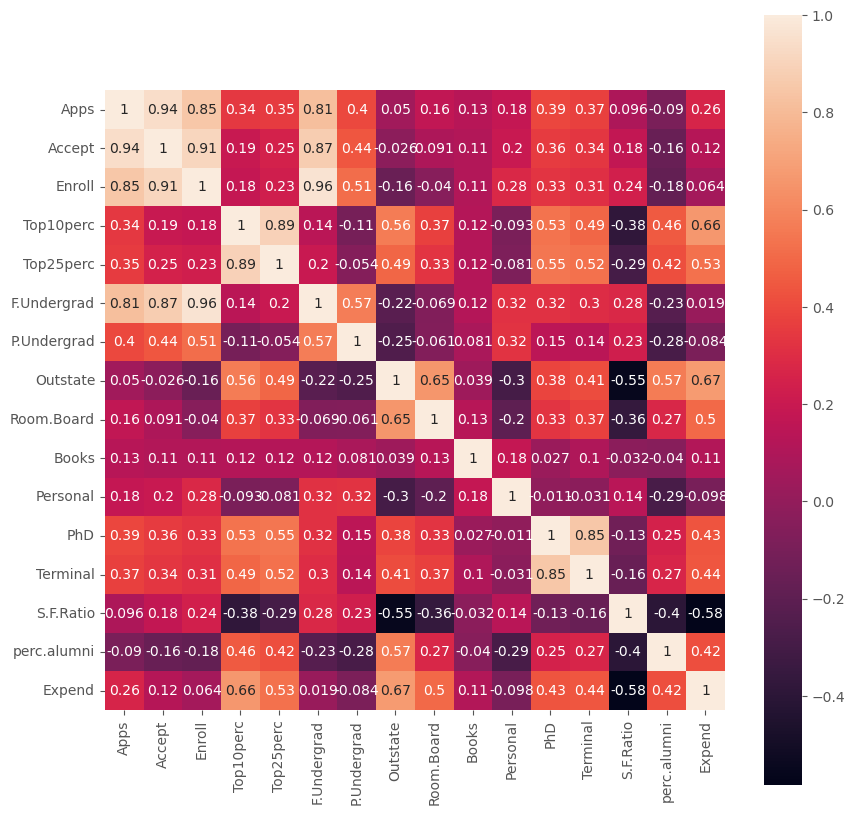

In [115]:
# Nhập code của bạn ở đây
plt.figure(figsize = (10, 10))
sns.heatmap(corr, annot = True, square = True)

# Task 4: Vẽ biểu đồ Scatter từng đặc trưng với mục tiêu

Lấy ra toàn bộ đặc trưng từ dữ liệu và loại bỏ đi mục tiêu ("Accept")

In [116]:
# Nhập code của bạn ở đây
target = "Accept"
feature = df.columns[1:-1].difference(['Accept'])
feature_df = df[feature]
target_df = df["Accept"]

In [117]:
feature_df.head()

,Apps,Books,Enroll,Expend,F.Undergrad,Outstate,P.Undergrad,Personal,PhD,Room.Board,S.F.Ratio,Terminal,Top10perc,Top25perc,perc.alumni
Abilene Christian University,1660,450,721,7041,2885,7440,537,2200,70,3300,18.1,78,23,52,12
Adelphi University,2186,750,512,10527,2683,12280,1227,1500,29,6450,12.2,30,16,29,16
Adrian College,1428,400,336,8735,1036,11250,99,1165,53,3750,12.9,66,22,50,30
Agnes Scott College,417,450,137,19016,510,12960,63,875,92,5450,7.7,97,60,89,37
Alaska Pacific University,193,800,55,10922,249,7560,869,1500,76,4120,11.9,72,16,44,2


Trực quan từng đặc trưng với mục tiêu

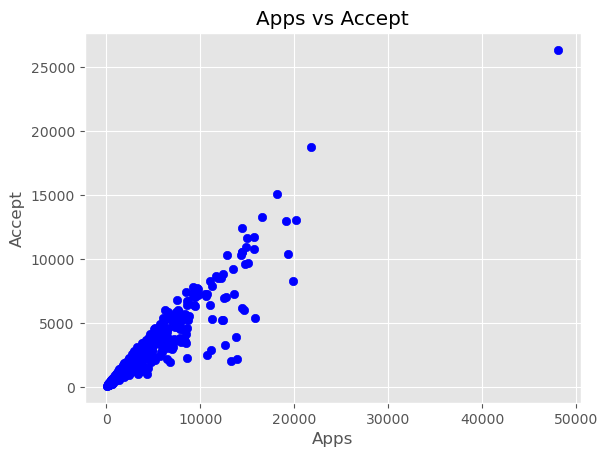

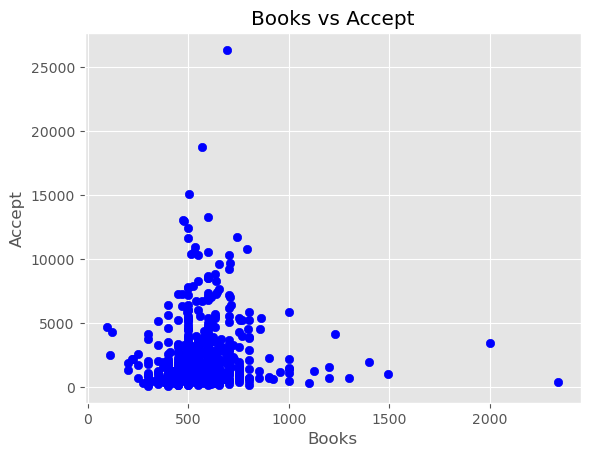

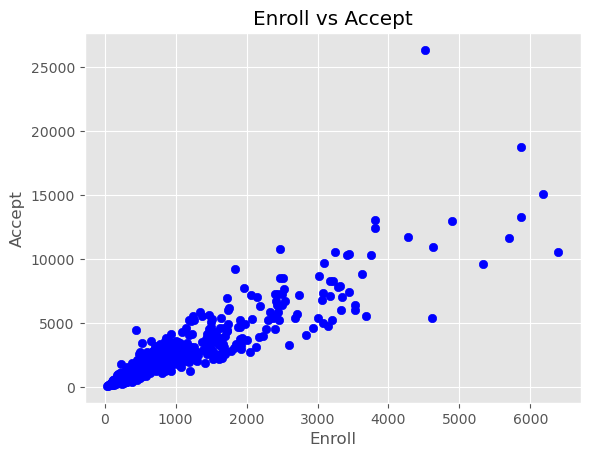

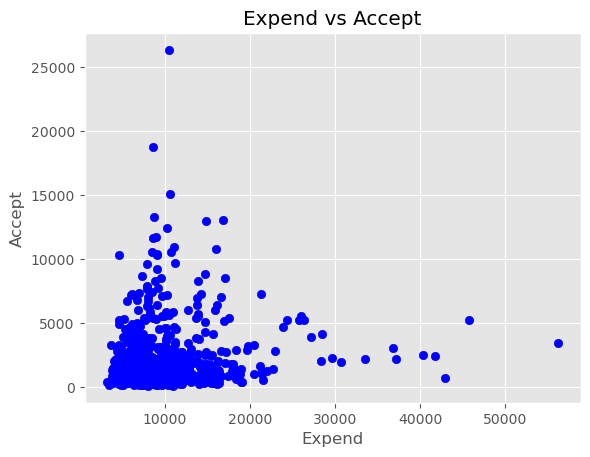

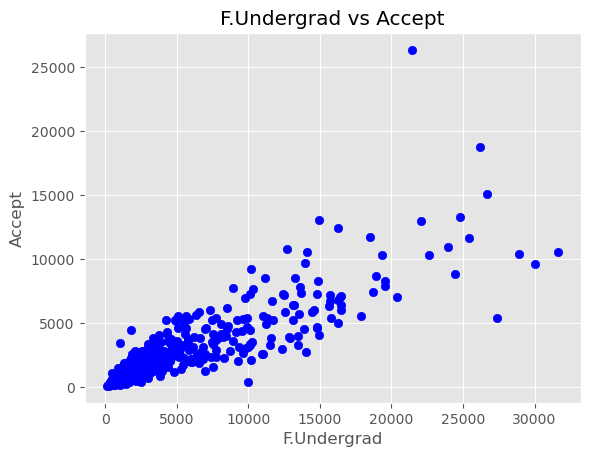

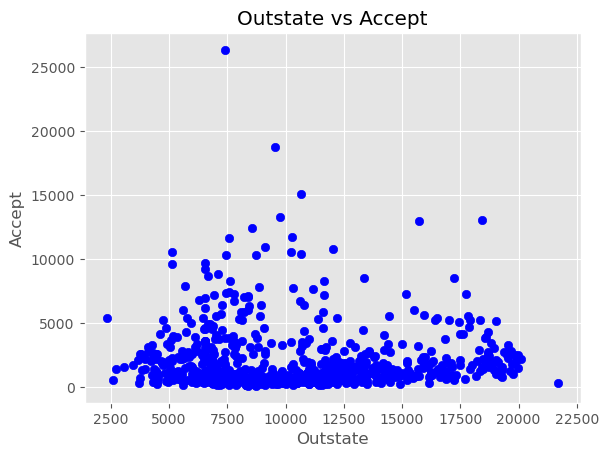

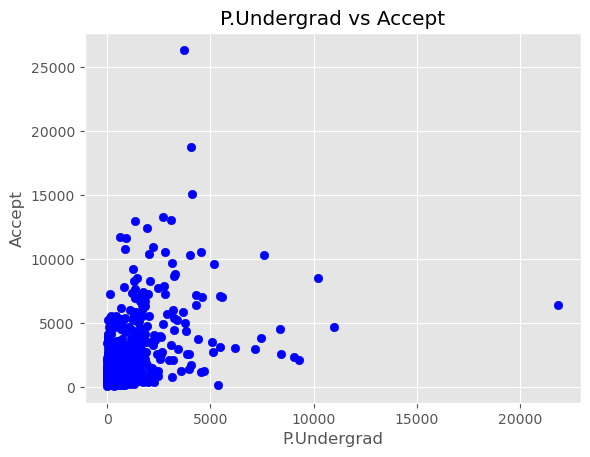

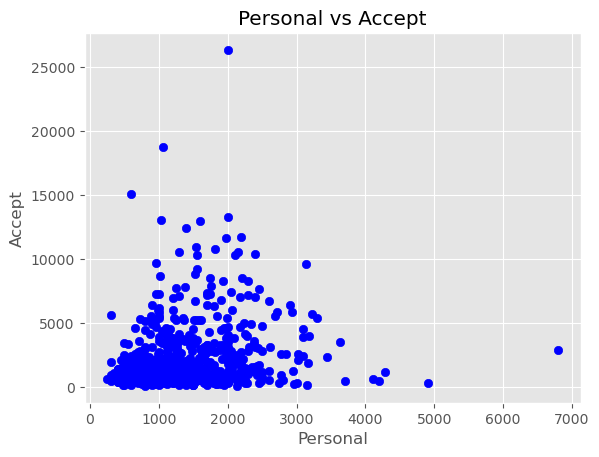

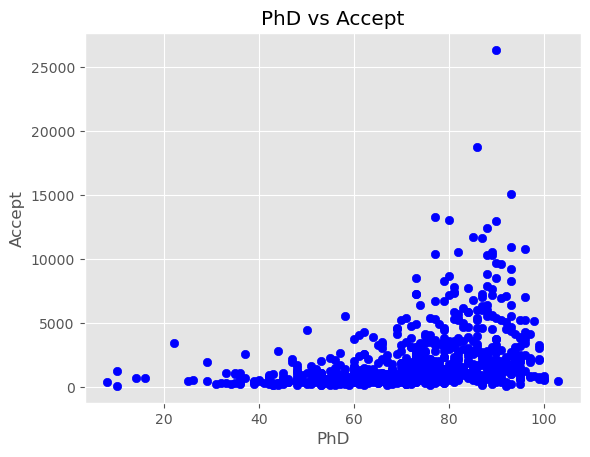

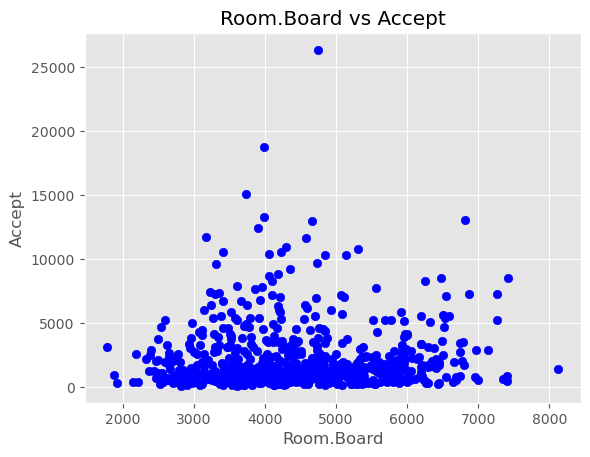

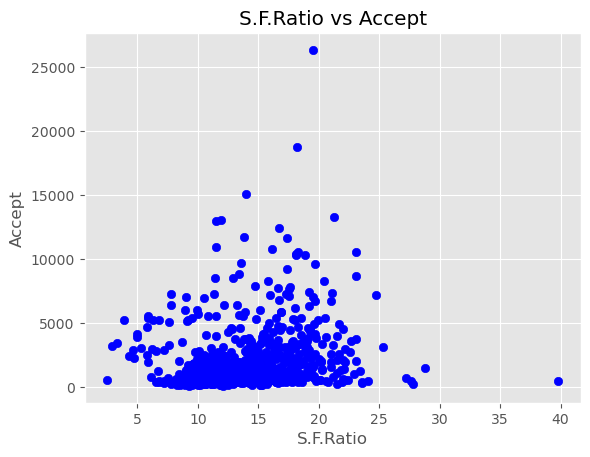

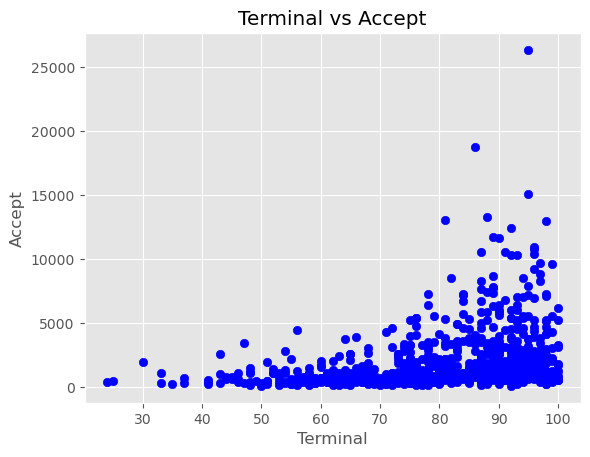

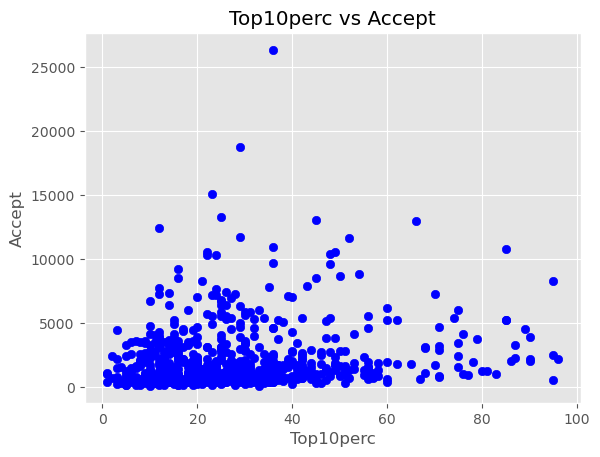

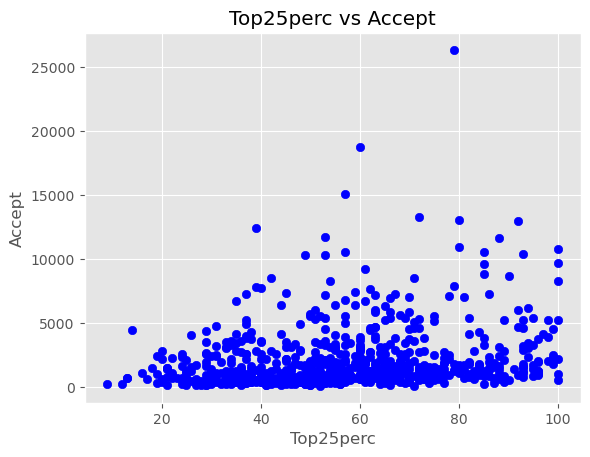

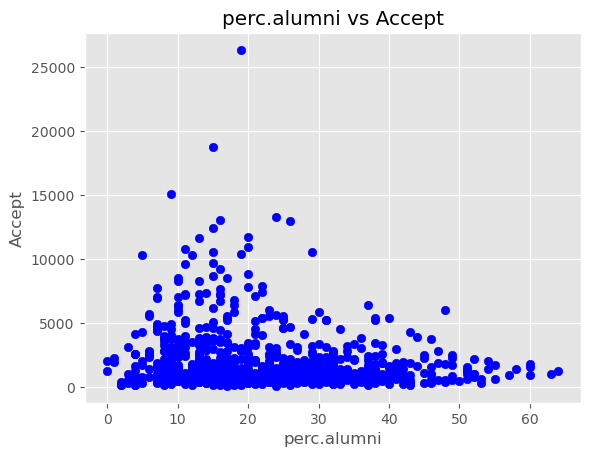

In [118]:
# Nhập code của bạn ở đây

for i, feature in enumerate(feature_df):
	plt.scatter(df[feature], target_df, color = 'blue')
	plt.title(f'{feature} vs {target}')
	plt.xlabel(feature)
	plt.ylabel(target)
	plt.show()

# Hiển thị biểu đồ

# Task 5: Phân tách dữ liệu đặc trưng vào X, dữ liệu mục tiêu vào y từ dữ liệu gốc


In [119]:
# Nhập code của bạn ở đây
X = df[df.columns[0:-1].difference(['Accept'])]
y = df[["Accept"]]

In [120]:
X.head()

,Apps,Books,Enroll,Expend,F.Undergrad,Outstate,P.Undergrad,Personal,PhD,Private,Room.Board,S.F.Ratio,Terminal,Top10perc,Top25perc,perc.alumni
Abilene Christian University,1660,450,721,7041,2885,7440,537,2200,70,1,3300,18.1,78,23,52,12
Adelphi University,2186,750,512,10527,2683,12280,1227,1500,29,1,6450,12.2,30,16,29,16
Adrian College,1428,400,336,8735,1036,11250,99,1165,53,1,3750,12.9,66,22,50,30
Agnes Scott College,417,450,137,19016,510,12960,63,875,92,1,5450,7.7,97,60,89,37
Alaska Pacific University,193,800,55,10922,249,7560,869,1500,76,1,4120,11.9,72,16,44,2


In [121]:
y.head()

,Accept
Abilene Christian University,1232
Adelphi University,1924
Adrian College,1097
Agnes Scott College,349
Alaska Pacific University,146


# Task 6: Tách dữ liệu thành train/test data

Dữ liệu train chiếm 70% và random_state là 7.

In [122]:
from sklearn.model_selection import train_test_split

# Nhập code của bạn ở đây
X_train, X_test, y_train, y_test = train_test_split(feature_df, target_df, test_size = 0.3, random_state = 7)

# Task 7: Mô hình hóa hồi quy tuyến tính chi phí ăn ở và số lượng sinh viên được chấp nhận và trực quan mô hình

Tách dữ liệu chi phí ăn ở từ bộ train và test

In [123]:
# Nhập code của bạn ở đây
X_train_rb = X_train[["Room.Board"]]
X_test_rb = X_test[["Room.Board"]]
y_train_rb = y_train
y_test_rb = y_test

In [124]:
X_train_rb.shape, X_test_rb.shape, y_train_rb.shape, y_test_rb.shape

((543, 1), (234, 1), (543,), (234,))

Điều chỉnh shape dữ liệu phù hợp với đầu vào của mô hình

Mô hình hồi quy tuyến tính yêu cầu đầu vào có dạng là (m, n) với X và (m, 1) với y.

Trong đó:

- m là số lượng mẫu quan sát

- n là số lượng đặc trưng

Với một đặc trưng duy nhất, shape phù hợp sẽ là (m, 1) cho X.

In [125]:
# Nhập code của bạn ở đây


Xây dựng và huấn luyện mô hình

In [126]:
# Nhập code của bạn ở đây
model_1 = LinearRegression()
model_1.fit(X_train_rb, y_train_rb)

LinearRegression()

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [127]:
# Nhập code của bạn ở đây
R2 = model_1.score(X_test_rb, y_test_rb)
R2

-0.0026669864145500988

Trực quan mô hình hóa với dữ liệu test

R2: -0.0026669864145500988
Intercept(s):  1340.6195651898383


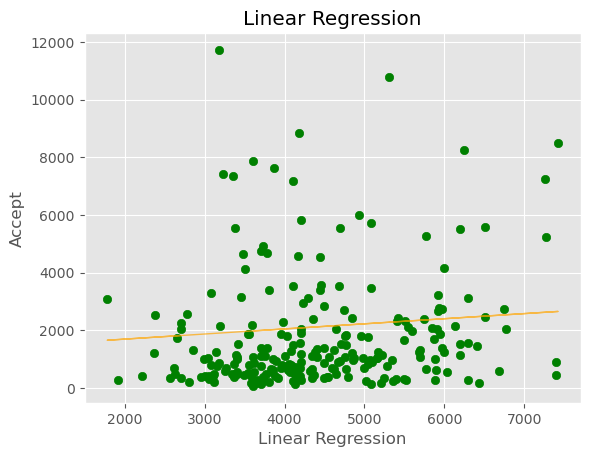

In [128]:
# Nhập code của bạn ở đây
drawLine(model_1, X_test_rb, y_test_rb, "Linear Regression")

# Task 8: Mô hình hóa hồi quy tuyến tính số lượng sinh viên ghi danh cho mỗi trường đại học và số lượng sinh viên được chấp nhận và trực quan mô hình

Tách dữ liệu số lượng sinh viên ghi danh cho mỗi trường đại học ở từ bộ train và test

In [129]:
# Nhập code của bạn ở đây
X_train_enroll = X_train[["Enroll"]]
X_test_enroll = X_test[["Enroll"]]
y_train_enroll = y_train
y_test_enroll = y_test

Điều chỉnh shape phù hợp với đầu vào của mô hình

In [130]:
# Nhập code của bạn ở đây
X_train_enroll.shape, X_test_enroll.shape, y_train_enroll.shape, y_test_enroll.shape

((543, 1), (234, 1), (543,), (234,))

Xây dựng và huấn luyện mô hình

In [131]:
# Nhập code của bạn ở đây
model_2 = LinearRegression()
model_2.fit(X_train_enroll, y_train_enroll)

LinearRegression()

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [132]:
# Nhập code của bạn ở đây
R2 = model_2.score(X_test_enroll, y_test_enroll)
R2

0.8578204867356156

Trực quan mô hình với dữ liệu test

R2: 0.8578204867356156
Intercept(s):  151.72611242276275


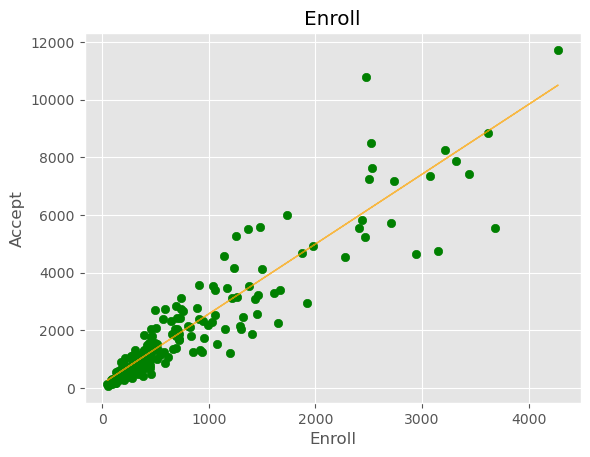

In [133]:
# Nhập code của bạn ở đây
drawLine(model_2, X_test_enroll, y_test_enroll, "Enroll")

# Task 9: Mô hình hóa hồi quy tuyến tính từng đặc trưng với số lượng sinh viên được chấp nhận và trực quan hóa mô hình với dữ liệu test

Lưu ý: Sử dụng vòng lặp

R2: 0.8278338672174985
Intercept(s):  215.6692108359373


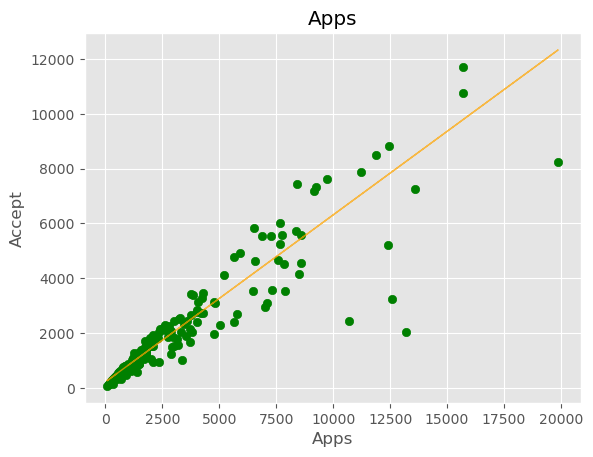

R2: 0.012015078321136241
Intercept(s):  1304.8355956198197


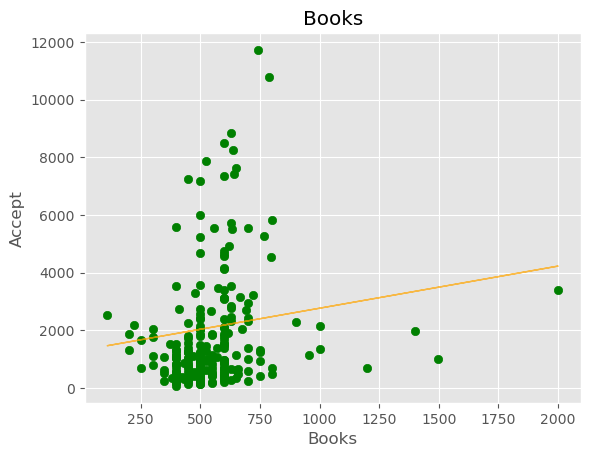

R2: 0.8578204867356156
Intercept(s):  151.72611242276275


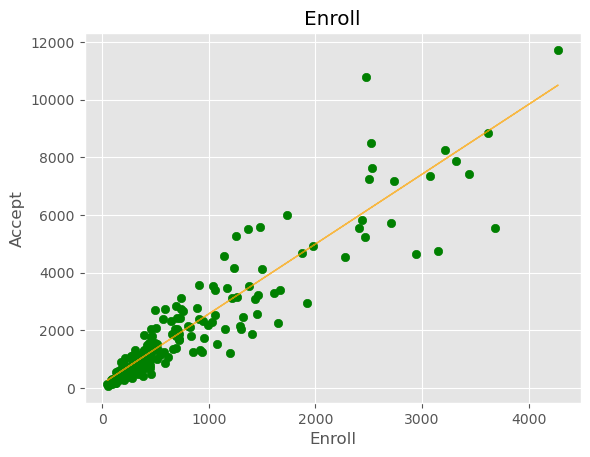

R2: 0.019419509650065114
Intercept(s):  1652.5167772242703


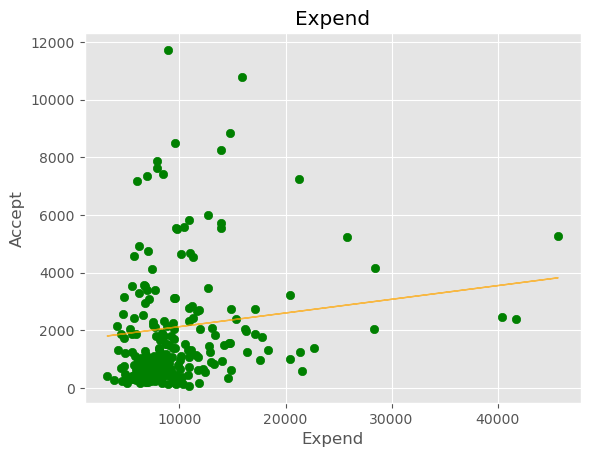

R2: 0.7779917973754006
Intercept(s):  380.94291049842764


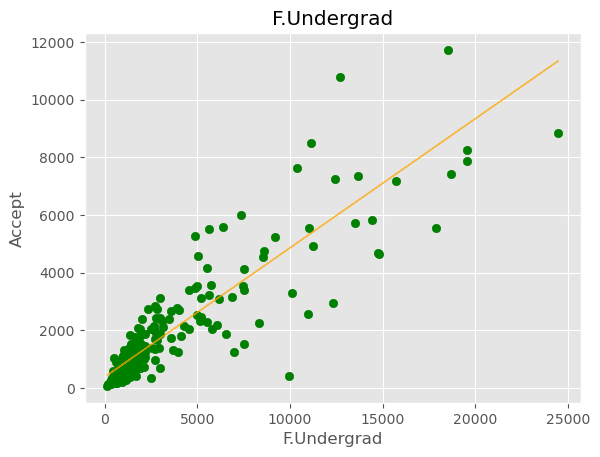

R2: -0.03441717957246193
Intercept(s):  2472.2978115697347


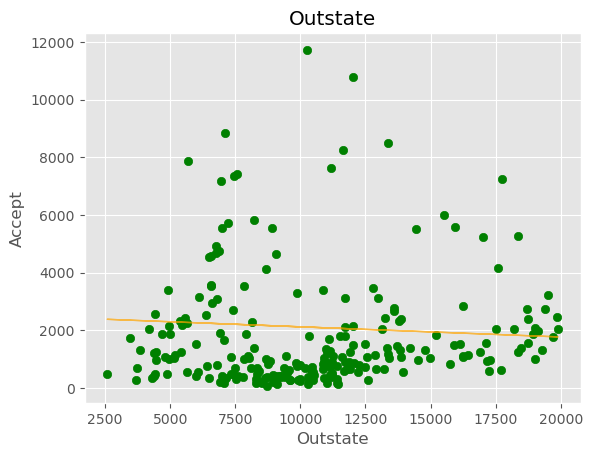

R2: 0.15365724454940077
Intercept(s):  1444.348151749116


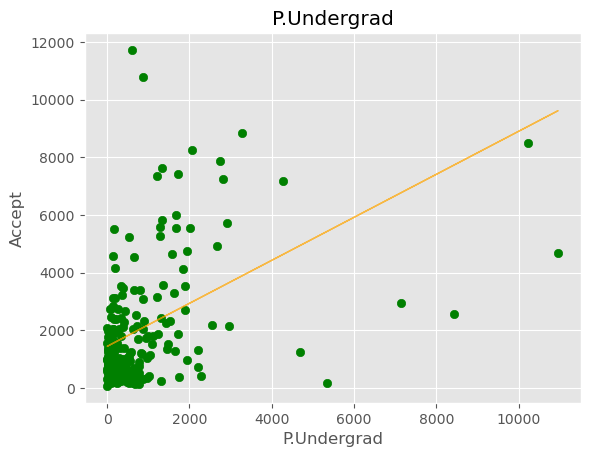

R2: 0.053082024881150325
Intercept(s):  1185.975607940944


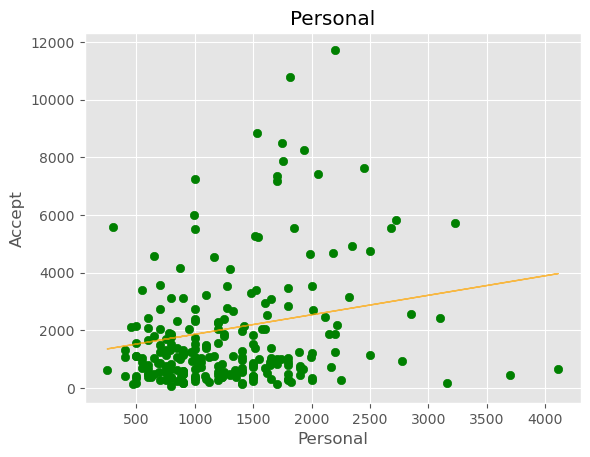

R2: 0.14442475831652202
Intercept(s):  -1901.7356825532383


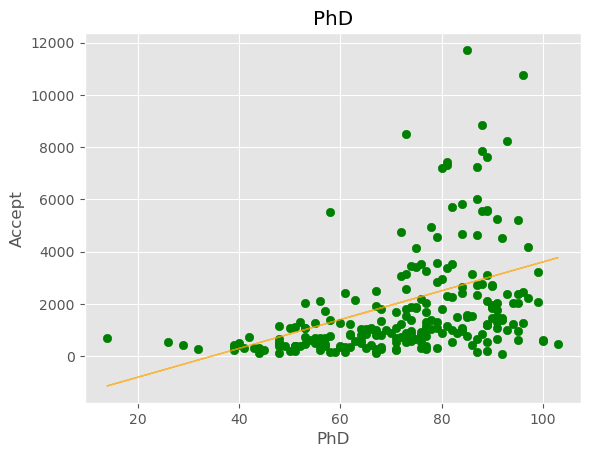

R2: -0.0026669864145500988
Intercept(s):  1340.6195651898383


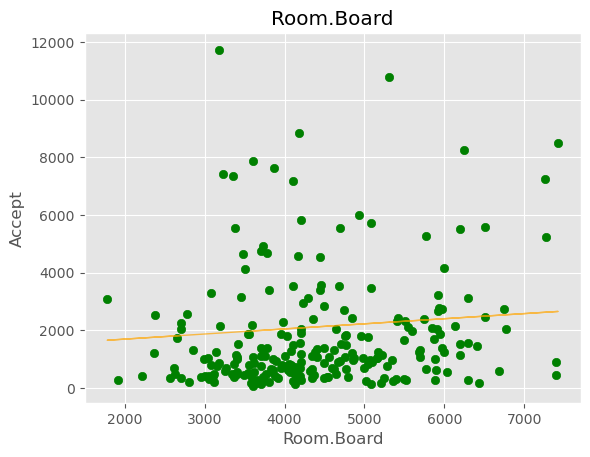

R2: -0.0012154874950456307
Intercept(s):  406.0892030188852


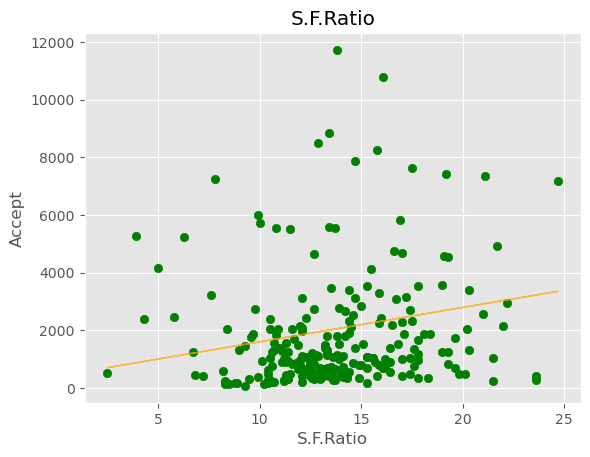

R2: 0.10721305445042717
Intercept(s):  -2566.341123006577


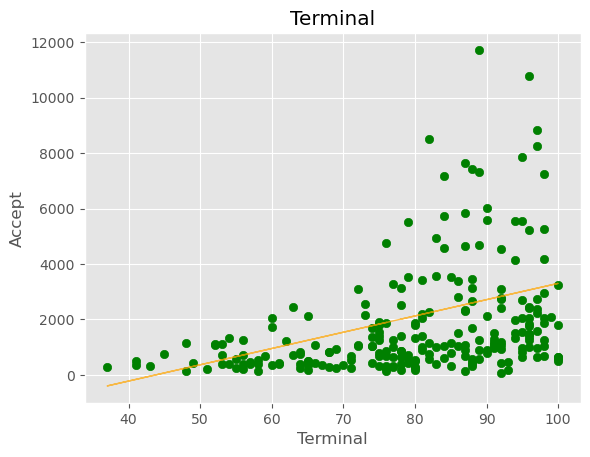

R2: 0.046531790535434436
Intercept(s):  1397.3784275961893


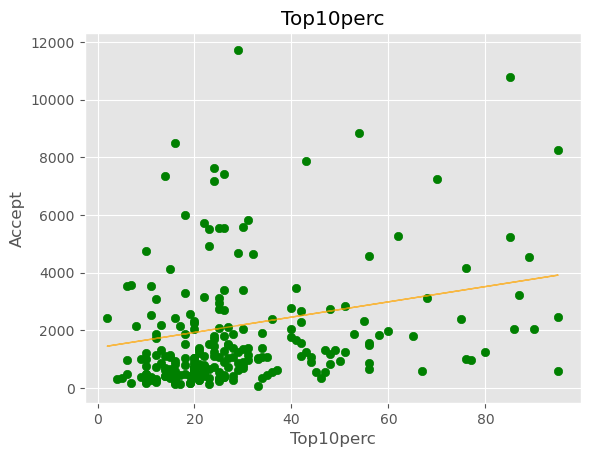

R2: 0.05631647635294579
Intercept(s):  378.8846828301894


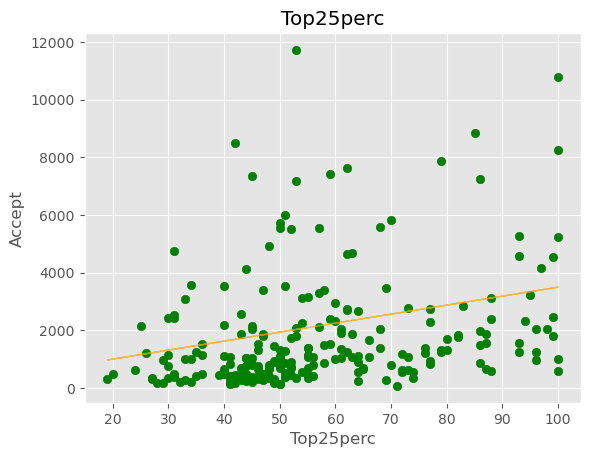

R2: 0.006075121043538134
Intercept(s):  2869.319570792186


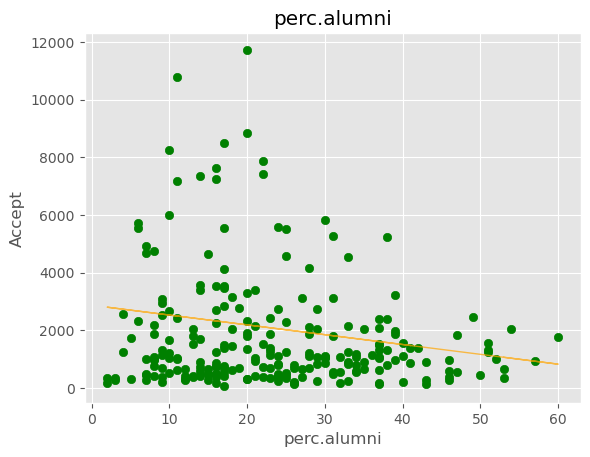

In [134]:
# Nhập code của bạn ở đây

features = df.columns[1:-1].difference(['Accept'])
for feature in features:
	X_train_temp = X_train[[feature]]
	X_test_temp = X_test[[feature]]
	model_temp = LinearRegression()
	model_temp.fit(X_train_temp, y_train)
	drawLine(model_temp, X_test_temp, y_test, feature)

# Task 10: Mô hình hóa hồi quy tuyến đa biến số lượng sinh viên ghi danh cho mỗi trường đại học và chi phí ăn ở để dự đoán số lượng sinh viên được chấp nhận và trực quan mô hình

Tách dữ liệu số lượng sinh viên ghi danh cho mỗi trường đại học và chi phí ăn ở từ bộ train và test

In [135]:
# Nhập code của bạn ở đây
X_train_enroll_rb = X_train[["Enroll", "Room.Board"]]
X_test_enroll_rb = X_test[["Enroll", "Room.Board"]]
y_train_enroll_rb = y_train
y_test_enroll_rb = y_test

Điều chỉnh shape phù hợp với đầu vào của mô hình.

Lưu ý dữ liệu của chúng ta ở phần này là 2 đặc trưng, do đó đầu vào của mô hình đối với X sẽ là (m, 2)

In [136]:
# Nhập code của bạn ở đây
X_train_enroll_rb.shape, X_test_enroll_rb.shape, y_train_enroll_rb.shape, y_test_enroll_rb.shape

((543, 2), (234, 2), (543,), (234,))

Xây dựng và huấn luyện mô hình

In [137]:
# Nhập code của bạn ở đây
model_3 = LinearRegression()
model_3.fit(X_train_enroll_rb.values, y_train_enroll_rb.values)

LinearRegression()

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [138]:
# Nhập code của bạn ở đây
R2 = model_3.score(X_test_enroll_rb, y_test_enroll_rb)
R2

C:\Users\Khoaddow\anaconda3\envs\main\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


0.8764371774214047

Trực quan mô hình với dữ liệu test

R2: 0.8764371774214047
Intercept(s):  -1176.6284824940826


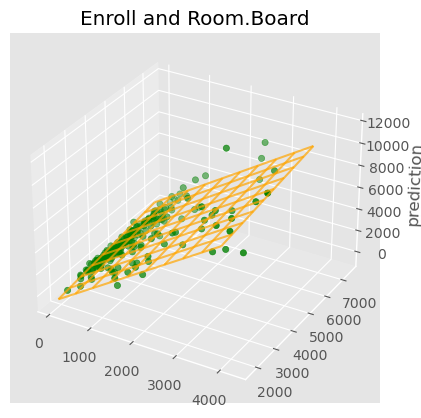

In [139]:
# Nhập code của bạn ở đây
drawPlane(model_3, X_test_enroll_rb, y_test_enroll_rb, "Enroll and Room.Board")

# Task 11: Sử dụng hồi quy tuyến tính với toàn bộ đặc trưng để quan sát tác động của từng đặc trưng đến mục tiêu

Tạo một bản sao về dữ liệu train và test

In [140]:
# Nhập code của bạn ở đây
X_train_temp = X_train
X_test_temp = X_test
y_train_temp = y_train
y_test_temp = y_test

Điều chỉnh shape phù hợp với đầu vào của mô hình.

Lưu ý rằng đầu vào của mô hình lúc này sẽ là (m, n).

In [141]:
# Nhập code của bạn ở đây
X_train_temp.shape, X_test_temp.shape, y_train_temp.shape, y_test_temp.shape

((543, 15), (234, 15), (543,), (234,))

Trong hồi quy tuyến tính, đặc trưng có miền giá trị lớn hơn sẽ chiếm ưu thế hơn so với đặc trưng có miền giá trị nhỏ hơn. Để công bằng cho tất cả dặc trưng chúng ta sẽ áp dụng một phương pháp được gọi là co dãn đặc trưng

In [142]:
from sklearn.preprocessing import StandardScaler

# Nhập code của bạn ở đây
X_train_temp = StandardScaler().fit(X_train_temp).transform(X_train_temp.astype(float))
X_test_temp = StandardScaler().fit(X_test_temp).transform(X_test_temp.astype(float))


Xây dựng và huấn luyện mô hình

In [143]:
# Nhập code của bạn ở đây
model_11 = LinearRegression()
model_11.fit(X_train_temp, y_train_temp)
model_11

LinearRegression()

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [144]:
# Nhập code của bạn ở đây
R2 = model_11.score(X_test_temp, y_test_temp)
R2

0.8047204503783061

Quan sát trong số đối với từng đặc trưng để kiểm tra xem đặc trưng nào có tác động mạnh hơn tới số lượng sinh viên được chấp nhận.

Đối chiếu trọng số của từng đặc trưng với ma trận trực quan để đối chiếu kết quả, nếu giá trị trong ma trận tương quan là dương lớn thì tham số đối với đặc trưng đó sẽ lớn và ngược lại.

Để hoàn thành được phần này, bạn hãy tham khảo và tìm ra cách lấy trọng số cho các đặc trưng từ [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) của Sklearn

In [192]:
features = df.columns[1:-1].difference(['Accept'])
correlation_matrix = df.corr()
weights = model_11.coef_
bias = model_11.intercept_
max_w, min_w = weights[0], weights[1]
max_feature, min_feature = features[0], features[1]
features_new = []
for i, feature in enumerate(features):
	print(f"Đặc trưng {feature}:")
	print(f"  - Tương quan với y: {correlation_matrix[feature]['Accept']:.2f}")
	print(f"  - Trọng số từ mô hình: {weights[i]:.2f}")
	if max_w < weights[i]:
		max_w = weights[i]
		max_feature = feature
	if min_w > weights[i]:
		min_w = weights[i]
		min_feature = feature

	if correlation_matrix[feature]['Accept'] > 0:
		features_new.append(feature)

print(f"Đặc trưng max: {max_feature}")
print(f"  - Tương quan với y: {correlation_matrix[max_feature]['Accept']:.2f}")
print(f"  - Trọng số từ mô hình: {max_w:.2f}")
print(f"Đặc trưng min: {min_feature}")
print(f"  - Tương quan với y: {correlation_matrix[min_feature]['Accept']:.2f}")
print(f"  - Trọng số từ mô hình: {min_w:.2f}")



Đặc trưng Apps:
  - Tương quan với y: 0.94
  - Trọng số từ mô hình: 1771.22
Đặc trưng Books:
  - Tương quan với y: 0.11
  - Trọng số từ mô hình: 0.06
Đặc trưng Enroll:
  - Tương quan với y: 0.91
  - Trọng số từ mô hình: 1181.37
Đặc trưng Expend:
  - Tương quan với y: 0.12
  - Trọng số từ mô hình: -162.43
Đặc trưng F.Undergrad:
  - Tương quan với y: 0.87
  - Trọng số từ mô hình: -186.34
Đặc trưng Outstate:
  - Tương quan với y: -0.03
  - Trọng số từ mô hình: 299.65
Đặc trưng P.Undergrad:
  - Tương quan với y: 0.44
  - Trọng số từ mô hình: -60.58
Đặc trưng Personal:
  - Tương quan với y: 0.20
  - Trọng số từ mô hình: -17.99
Đặc trưng PhD:
  - Tương quan với y: 0.36
  - Trọng số từ mô hình: 76.73
Đặc trưng Room.Board:
  - Tương quan với y: 0.09
  - Trọng số từ mô hình: -8.10
Đặc trưng S.F.Ratio:
  - Tương quan với y: 0.18
  - Trọng số từ mô hình: -45.57
Đặc trưng Terminal:
  - Tương quan với y: 0.34
  - Trọng số từ mô hình: 2.11
Đặc trưng Top10perc:
  - Tương quan với y: 0.19
  - Trọng số

**Câu hỏi: Đặc trưng nào có tác động mạnh nhất đến số lượng sinh viên được chấp nhận ?**

Trả lời (nhấn vào đây để trả lời):
Đặc trưng max: Apps
  - Tương quan với y: 0.94
  - Trọng số từ mô hình: 1771.22

**Câu hỏi: Đặc trưng nào có tác động ít nhất đến số lượng sinh viên được chấp nhận ?**

Trả lời (nhấn vào đây để trả lời):
Đặc trưng min: Top10perc
  - Tương quan với y: 0.19
  - Trọng số từ mô hình: -497.04

# Task 12: Xây dựng mô hình hồi quy tuyến tính của riêng bạn

Tùy ý chọn đặc trưng và điều chỉnh siêu tham số

Yêu cầu: R2 score >= 0.9


In [198]:
# Nhập code của bạn ở đây
# feature_df = df[features_new]
# target_df = df["Accept"]
X = df[features_new]
y = df[["Accept"]]
model_12 = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train = StandardScaler().fit(X_train).transform(X_train.astype(float))
X_test = StandardScaler().fit(X_test).transform(X_test.astype(float))

model_12.fit(X_train, y_train)
r2 = model_12.score(X_test, y_test)
r2

0.9070263503481003

**Câu hỏi: Hãy giải thích quá trình lý do lựa chọn đặc trưng, các tham số điều chỉnh để đạt được R2 score >= 0.9**

Trả lời (nhấn vào đây để trả lời):
- Bỏ những feature có độ tương quan nhỏ hơn không
- random_state = 42 để tạo ra kết quả ổn định của việc random


# Task 13: Sử dụng hồi quy Lasso để chọn ra đặc trưng tốt nhất để dự đoán số lượng sinh viên được chấp nhận.

Hồi quy Lasso là hồi quy tuyến tính đặc biệt được tinh chỉnh để có thể đưa các tham số của các đặc trưng không quan trọng tiến về 0 và còn lại các đặc trưng quan trọng.

Alpha càng lớn, tham số của các đặc trưng không quan trọng càng nhỏ và tiến về 0 nhanh.

Yêu cầu: Tìm giá trị alpha sao cho mô hình đạt R2 score >= 0.92

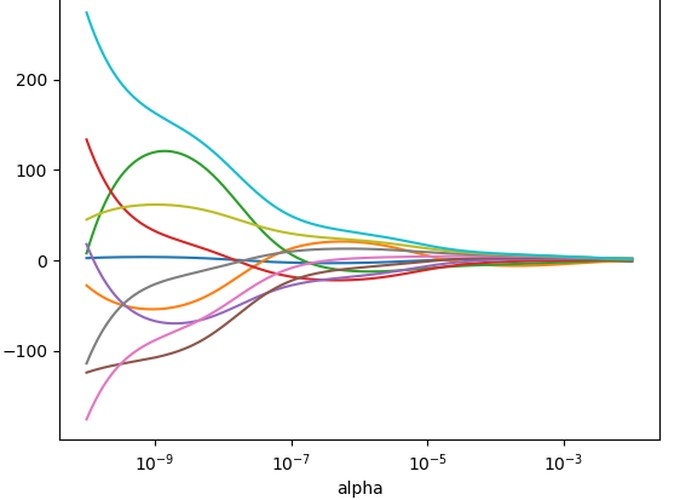

In [236]:
from sklearn.linear_model import Lasso

features_13 = df.columns[1:-1].difference(['Accept'])
# Nhập code của bạn ở đây
X = df[features_13]
y = df[["Accept"]]
model_13 = Lasso(alpha = 0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
model_13.fit(X_train, y_train)


Lasso(alpha=0.1)

Đánh giá chất lượng mô hình bằng chỉ số R2 cho tập test

In [237]:
# Nhập code của bạn ở đây
r2 = model_13.score(X_test, y_test)
r2

0.9271862612478371

Quan sát tham số với từng đặc trưng để kiểm tra xem đặc trưng nào bị loại bỏ bằng phương pháp Lasso

In [238]:
# Nhập code của bạn ở đây
coefficients = model_13.coef_
coefficients

array([ 4.20598181e-01, -3.73121880e-02,  1.16371818e+00, -1.33950464e-02,
       -2.28582196e-02,  5.70332828e-02, -7.26643874e-03, -4.57910590e-02,
        3.85330842e+00, -1.31748454e-02, -4.49359054e+00, -9.48394485e-01,
       -2.73748335e+01,  9.28409170e+00, -3.93747725e+00])

**Câu hỏi: Đặc trưng nào bị loại bỏ trong hồi quy Lasso ?**

In [235]:
# Kết quả

print("Trọng số của từng đặc trưng:")
for feature, coef in zip(features, coefficients):
	print(f"{feature}: {coef:.2f}")

# Xác định các đặc trưng bị loại bỏ
eliminated_features = [feature for feature, coef in zip(features_13, coefficients) if coef == 0]
print("\nĐặc trưng bị loại bỏ:", eliminated_features)

Trọng số của từng đặc trưng:
Apps: 0.42
Books: -0.04
Enroll: 1.16
Expend: -0.01
F.Undergrad: -0.02
Outstate: 0.06
P.Undergrad: -0.01
Personal: -0.05
PhD: 3.86
Room.Board: -0.01
S.F.Ratio: -4.51
Terminal: -0.95
Top10perc: -27.38
Top25perc: 9.29
perc.alumni: -3.94

Đặc trưng bị loại bỏ: []


Trả lời (nhấn vào đây để trả lời):